In [1]:
import pandas as pd
import numpy as np
from os.path import join
from mlxtend.evaluate import permutation_test
from scipy.stats import kstest 

In [2]:
def name_mapping(previous_feature_names):
    """
    The goal of this new method is to convert feature names 
    saved with the ML model into the new feature names.
    """
    corrected_feature_names={}
    for f in previous_feature_names:
        if 'mb' in f and 'temperature' in f:
            new_f = f.replace('mb','')
        elif 'dewpoint' in f and 'mb' in f:
            new_f = f.replace('mb','').replace('dewpoint', 'td')
        elif 'geopotential' in f:
            new_f =f.replace('geopotential_height','geo_hgt').replace('mb', '')
        elif 'cloud_top_temp' in f:
            new_f =f.replace('cloud_top_temp','ctt')
        elif 'divergence' in f:
            new_f =f.replace('divergence_10m','div_10m')
        elif '10-m_bulk_shear' in f:
            new_f =f.replace('10-m_bulk_shear','10-500m_bulkshear')
        elif 'th_e_ml' in f:
            new_f =f.replace('th_e_ml','theta_e')
        elif '1to3km' in f or '3to5km' in f:
            new_f =f.replace('km_max','')
        elif 'bouyancy' in f:
            # Spelling error!
            new_f = f.replace('bouyancy','buoyancy')
        elif 'uh_0to2' in f:
            new_f = f.replace('uh_0to2', 'uh_0to2_instant')
        elif 'uh_2to5' in f:
            new_f = f.replace('uh_2to5', 'uh_2to5_instant')  
        elif 'wz_0to2' in f:
            new_f = f.replace('wz_0to2', 'wz_0to2_instant')    
            
        else:
            new_f = f
        
        # Additional '_' in the new format! 
        new_f = new_f.replace('_ens_mean', '__ens_mean')
        new_f = new_f.replace('_ens_std', '__ens_std')
        new_f = new_f.replace('_spatial_mean', '__spatial_mean')
        new_f = new_f.replace('_time_max', '__time_max')
        new_f = new_f.replace('_time_min', '__time_min')
        
        # New naming convention for amplitude stats! 
        new_f = new_f.replace('_ens_std_of_90th', '_amp_ens_std')
        new_f = new_f.replace('_ens_mean_of_90th', '_amp_ens_mean')
        new_f = new_f.replace('_ens_std_of_10th', '_amp_ens_std')
        new_f = new_f.replace('_ens_mean_of_10th', '_amp_ens_mean')
        
        #Baseline var
        #new_f = new_f.replace('uh_probs_>180_prob_max', 'uh_nmep_>180_3km__prob_max')
        #new_f = new_f.replace('hail_probs_>1.0_prob_max', 'hail_nmep_>1.0_3km__prob_max')
        #new_f = new_f.replace('wind_probs_>40_prob_max', 'wnd_nmep_>40_3km__prob_max')
        
        corrected_feature_names[f] = new_f

    return corrected_feature_names

In [3]:
def load_ml_data(lead_time = 'first_hour', 
                 mode = 'train',
                 cols_to_drop = ['label', 'obj_centroid_x', 
                                 'obj_centroid_y', 'Run Date', 
                                 'forecast_time_index'], 
                target_col = 'hail_severe_3km_obj_match',
                sanity_check=False 
                ): 
    """ Loads the ML dataset. """
    # Target Var : [tornado|wind|hail]_[severe|sig_severe]_[3km, 9km, 15km, 30km]_[obj_match | ]
    #base_path = '/work/mflora/ML_DATA/MLDATA'
    #file_path = join(base_path, f'wofs_ml_severe__{lead_time}__{mode}_data.feather')
    
    if sanity_check:
        base_path = '/work/mflora/ML_DATA/DATA'
        file_path = join(base_path, f'wofs_ml_severe__{lead_time}__data.feather')
    else:
        base_path = '/work/mflora/ML_DATA/MLDATA'
        file_path = join(base_path, f'wofs_ml_severe__{lead_time}__{mode}_data.feather')
        
    df = pd.read_feather(file_path)

    metadata = df[['Run Date', 'forecast_time_index', 'Initialization Time', 'label']]
    index = list(df.columns).index('hail_severe_3km_obj_match')
    possible_features = list(df.columns)[:index]

    drop_vars = ['QVAPOR', 'freezing_level', 'stp', 'okubo_weiss', ]
    
    features = [f for f in possible_features if f not in cols_to_drop]
    
    if sanity_check:
        features = [f for f in features if not any([d in f for d in drop_vars])]
    
    X = df[features]
    y = df[target_col]

    return X,y, metadata 

In [4]:
def load_original_data(mode='training', target='matched_to_severe_hail_0km'):
    df = pd.read_feather(
    f'/work/mflora/ML_DATA/DATA/original_first_hour_{mode}_{target}_data.feather')
    
    metadata = ['label', 'Run Time', 'Run Date', 'FCST_TIME_IDX']
    targets = ['matched_to_severe_hail_0km',
     'matched_to_severe_hail_15km',
     'matched_to_LSRs_0km',
     'matched_to_LSRs_15km',
     'matched_to_severe_wind_0km',
     'matched_to_severe_wind_15km',
     'matched_to_tornado_0km',
     'matched_to_tornado_15km']
    features = [f for f in df.columns if f not in targets+metadata]

    X = df[features].astype(float)
    y = df[target].astype(float).values
    
    dates = df['Run Date'].apply(str)
    
    return X, y, dates

In [5]:
def stat_testing(new_score, baseline_score):
    """
    Compute a p-value between two sets using permutation testing 
    to determined statistical significance. In this case,
    assess whether the ML performance is greater than the baseline.
    """
    p_value = permutation_test(new_score,
                              baseline_score,
                             'x_mean != y_mean',
                              method='approximate',
                               num_rounds=1000,
                               seed=0)
    return p_value

In [6]:
# Convert New to Old 
def convert(X, y, new_dates, old_dates):
    # Get the indices of dates within the old dates 
    cond = new_dates.isin(np.unique(old_dates))
    
    inds = np.where(cond==True)[0]
    
    X = X.iloc[inds]
    y = y[inds]
    new_dates = new_dates[inds]
    
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    new_dates.reset_index(drop=True, inplace=True)
    
    return X, y, new_dates

In [7]:
# Load the original training and testing dataset. 
X_org, y_org, train_dates = load_original_data(mode='training')

In [8]:
mapper = name_mapping(list(X_org.columns))

In [9]:
X,y, metadata = load_ml_data(target_col = 'hail_severe_3km', sanity_check=True)
new_dates = metadata['Run Date'].apply(str)
X_train, y_train, new_train_dates = convert(X, y, new_dates, train_dates)

In [10]:
X_2021 = pd.read_pickle('/work/mflora/ML_DATA/DATA/ml_dataset_first_hour_2021_reverted_names.pkl')
X_2021 = X_2021.astype(float)
columns = X_2021.columns 
data = X_2021.values.astype(float)
X_2021 = pd.DataFrame(data, columns=columns)

In [11]:
# 'dbz_3to5km_max_time_max_ens_mean_spatial_mean'
list(X_org.columns)

['srh_0to1_ens_mean_spatial_mean',
 'srh_0to3_ens_mean_spatial_mean',
 'cape_ml_ens_mean_spatial_mean',
 'cin_ml_ens_mean_spatial_mean',
 'shear_u_0to6_ens_mean_spatial_mean',
 'shear_v_0to6_ens_mean_spatial_mean',
 'shear_u_0to1_ens_mean_spatial_mean',
 'shear_v_0to1_ens_mean_spatial_mean',
 'lcl_ml_ens_mean_spatial_mean',
 'th_e_ml_ens_mean_spatial_mean',
 'u_10_ens_mean_spatial_mean',
 'v_10_ens_mean_spatial_mean',
 'mid_level_lapse_rate_ens_mean_spatial_mean',
 'low_level_lapse_rate_ens_mean_spatial_mean',
 'temperature_850mb_ens_mean_spatial_mean',
 'temperature_700mb_ens_mean_spatial_mean',
 'temperature_500mb_ens_mean_spatial_mean',
 'geopotential_height_850mb_ens_mean_spatial_mean',
 'geopotential_height_700mb_ens_mean_spatial_mean',
 'geopotential_height_500mb_ens_mean_spatial_mean',
 'dewpoint_850mb_ens_mean_spatial_mean',
 'dewpoint_700mb_ens_mean_spatial_mean',
 'dewpoint_500mb_ens_mean_spatial_mean',
 'uh_0to2_time_max_ens_mean_spatial_mean',
 'uh_2to5_time_max_ens_mean_sp

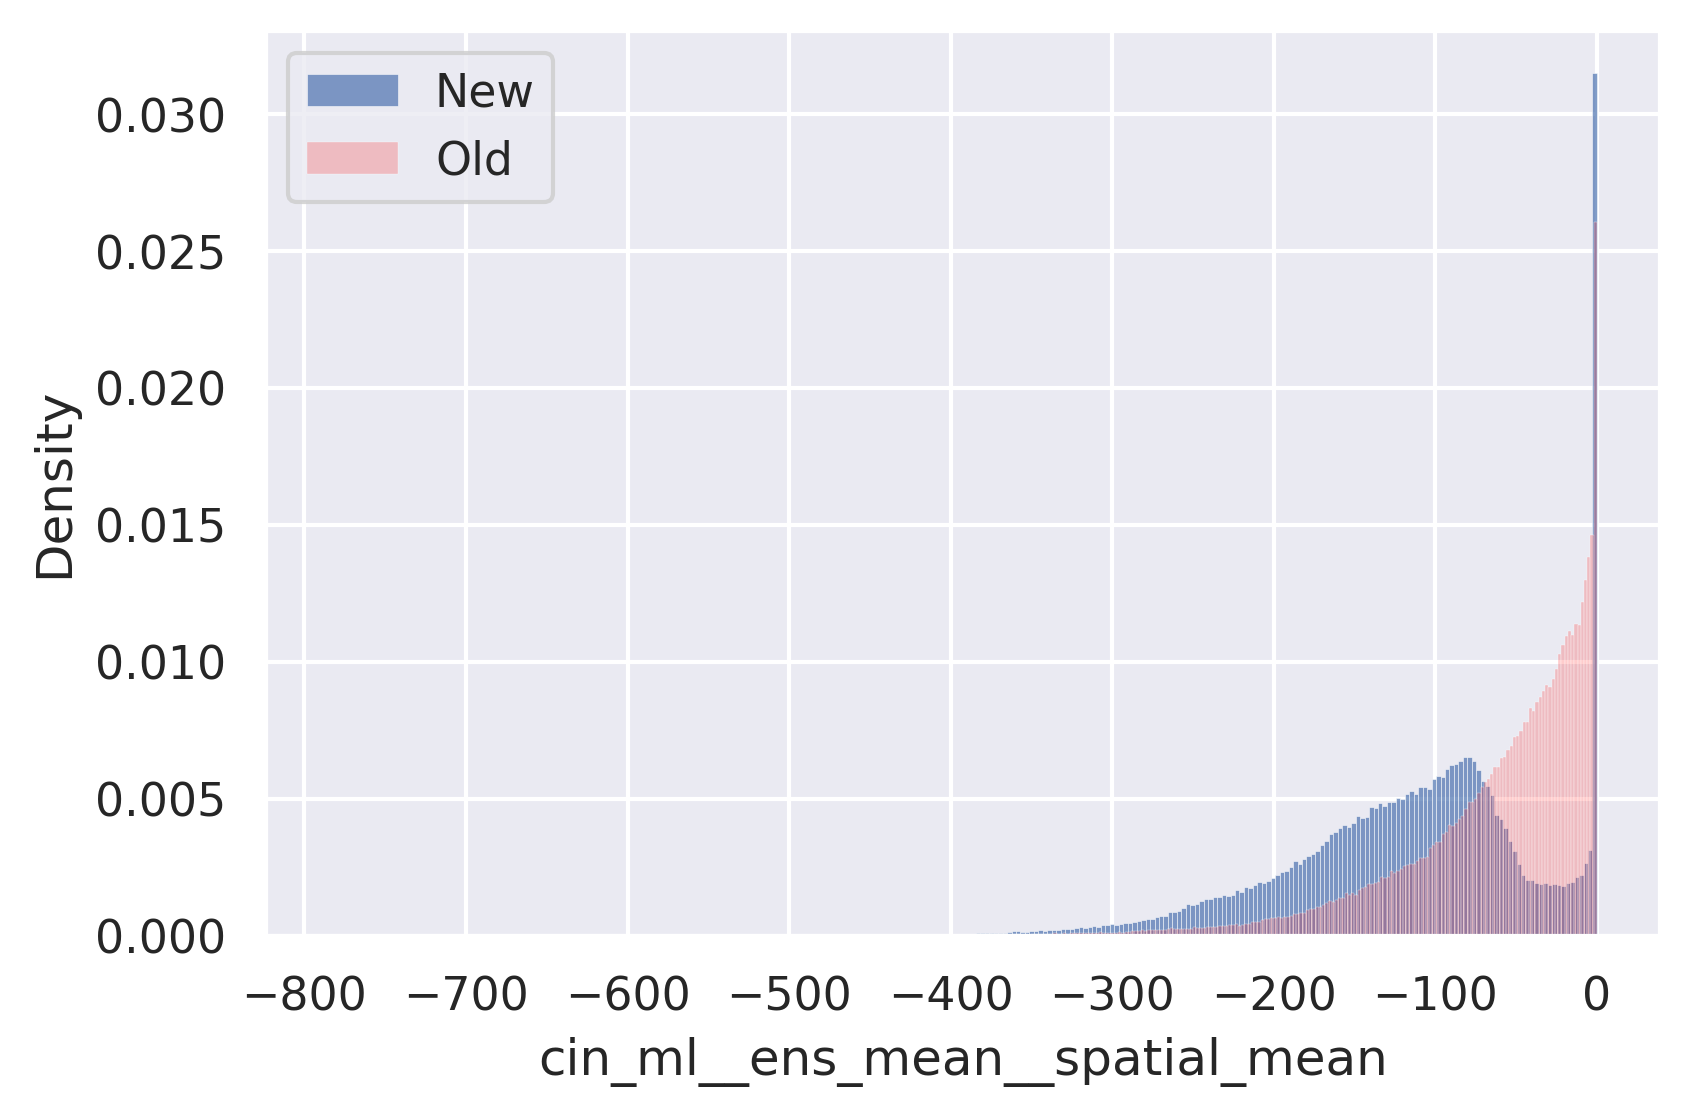

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme()

var = 'cin_ml_ens_mean_spatial_mean'

f, ax = plt.subplots(dpi=300)
sns.histplot(ax=ax, data=X_train, x=mapper[var], 
             legend=True, common_norm=False, stat='density', label='New', alpha=0.7)

sns.histplot(ax=ax, data=X_org, x=var, 
             legend=True, common_norm=False, stat='density', color='red', label='Old', alpha=0.2)

#sns.histplot(ax=ax, data=X_2021, x=var, 
#             legend=True, common_norm=False, stat='density', color='green', label='Old (2021)', alpha=0.2)

ax.legend()